# An introduction to the spectra package
## A package-to-be for calculating spectral statistics of many-body spectra

This notebook provides a quick introduction to the usage of the programming tools used for extraction of
the spectral statistics data that are most often used in my calculations. In order to install the ```spectral_stats ``` package, navigate to the root of the ```spectral_statistics_tools``` directory and issue the command
```pip install -e .```
This should install the ```spectral_stats``` package. To check this, run ```python``` and import the package:
```python
import spectral_stats
```
No error should be raised if everything went fine. This notebook shows some usage examples of the package.

In [1]:
# Import the necessary libraries, define some useful temporary helper routines, paths, etc.

%matplotlib notebook
import os
import sys
import glob
import numpy as np

from matplotlib import pyplot as plt
from spectral_stats.spectra import Spectra, _makehash

load_path = './example_data/L_16_Nu_8/'

# Load data
def load_data(path):
    
    cwd = os.getcwd()
    
    os.chdir(path)
    
    files = glob.glob('Eigvals*')
    files = np.array([np.fromfile(file) for file in files])
    os.chdir(cwd)
    return files

# load numerical data - a system with 16 sites, the ergodic case. 
spec_erg = load_data(load_path + 'ergodic/')

## Creation of a spectra class instance
The heart of our package lies in the implementation of the spectra class. The only necessary parameter
needed for the creation of a class instance is the ```spectrum``` 2D ```numpy``` array which stores an
ensemble of energy spectra for different disorder realization. After instantiation, the appropriate routines
take care of data-type conversion and make sure that 1D inputs are converted into 2D arrays so that no type
error is thrown. The instance creation syntax is as follows:
```python

spc = Spectra(spec_erg, *args, **kwargs)
```
Among the "publicly" accessible attributes of the class are ```spectrum``` and ```spectral_width```. The first contains the "working version" of the spectrum, which has already been resized or on which unfolding has been performed, if so specified. The resizing is performed in accordance with the ```spectral_width``` attribute, which controls the percentage of states that we consider in our calculations and their location in the spectrum. The Hilbert dimension of the resized spectrum and the number of random samples are stored in the attributes ```nener```
and ```nsamples```. The original spectrum is not meant to be changed, hence it is stored in the attribute ```_spectrum0```. Below is a simple usage example.

In [2]:
spc = Spectra(spec_erg);
print('Initial spectral width: {}'.format(spc.spectral_width))
print('Initial Hilbert space dimension {}. Initial number of samples: {}'.format(spc.nener, spc.nsamples))
# let's choose a different spectral width
spc.spectral_width = (0.25, 0.75)
print('Spectral width after change: {}'.format(spc.spectral_width))
print('After change. Hilbert space dimension {}. Number of samples: {}'.format(spc.nener, spc.nsamples))
# Hilbert space dimension and nsamples for the original spectrum are accessed by calling
# _nener and _nsamples, respectively.
print('Was the original spectrum affected? Hilbert space dimension {}. Number of samples: {}'.format(spc._nener, spc._nsamples))

Initial spectral width: (0.0, 1.0)
Initial Hilbert space dimension 12870. Initial number of samples: 1000
Spectral width after change: (0.25, 0.75)
After change. Hilbert space dimension 12870. Number of samples: 1000
Was the original spectrum affected? Hilbert space dimension 12870. Number of samples: 1000


## Some basic calculations - mean ratio of the adjacent level spacings
In order to calculate the mean ratio of the adjacent level spacings, one needs to first set the appropriate spectral width and then call the class function ```gap_avg()```. The return provides the mean value of the ratio of the adjacent level spacings and the standard deviation of the mean, calculated on different spectra obtained for different disorder realizations. 

In [3]:
# full spectrum
spc.spectral_width = (0., 1.)
print(spc.gap_avg())
# try a different percentage
spc.spectral_width = (0.25, 0.75)
print(spc.gap_avg())
spc.spectral_width = (0.45, 0.55)
print(spc.gap_avg())

(0.5302262217668838, 0.0026917712891319687)
(0.5306185489738856, 0.003838366398067687)
(0.5306460732249304, 0.008345748441908416)


## Some more involved calculations and operations - unfolding, filtering, sff

Let us now perform spectral unfolding; following an example, this can be done like shown below.

In [4]:
"""
Unfolding parameters:

n = 3-> the fitting polynomial degree
merge = False -> whether to merge spectra to a 
                 a single large spectrum before
                 finding the fitting polynomial
                 function or not.
correct_slope = False -> whether to correct for 
                         artifacts which are a 
                         consequence of unfolding
                         or not.
"""
spc.spectral_width = (0., 1.)
spc.spectral_unfolding(n=3, merge=False, correct_slope=False);

Performing spectral unfolding with the following settings: 
n: 3, merge: False, correct_slope: False 
spectral_width: (0.0, 1.0)


The data about the unfolded spectrum are retrieved by accessing the class attribute ```unfold_dict``` as shown below:

The contens of the unfold_dict are:
```python
"""
n -> the fitting polynomial degree
merged -> whether the unfolding was performed on a merged spectrum or on each
          spectrum in the ensemble individually
correct_slope -> whether slope correction was applied during the calculation
                 or not.
spectral_width -> width of the original spectrum on which the unfolding was
                  performed
discarded -> if slope correction is performed, some values in the unfolded
             spectrum might be discarded and their number is then stored.

"""

```

<IPython.core.display.Javascript object>


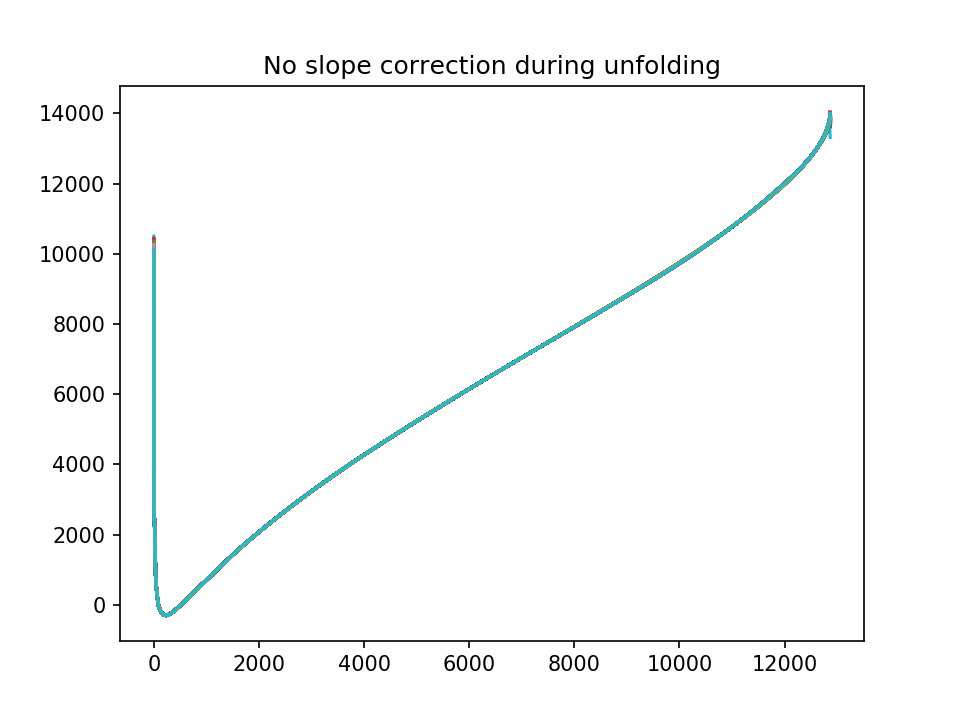

In [5]:
# check the output:
fig = plt.figure()
plt.title('No slope correction during unfolding')
for spec in spc.spectrum:
    plt.plot(spec)
plt.show()


We notice above there was a region of negative slope which is not physical, since the eigenvalues
are supposed to be organised in ascending order. We fix this using a slope correction algorithm.


Performing spectral unfolding with the following settings: 
n: 6, merge: False, correct_slope: True 
spectral_width: (0.0, 1)


<IPython.core.display.Javascript object>


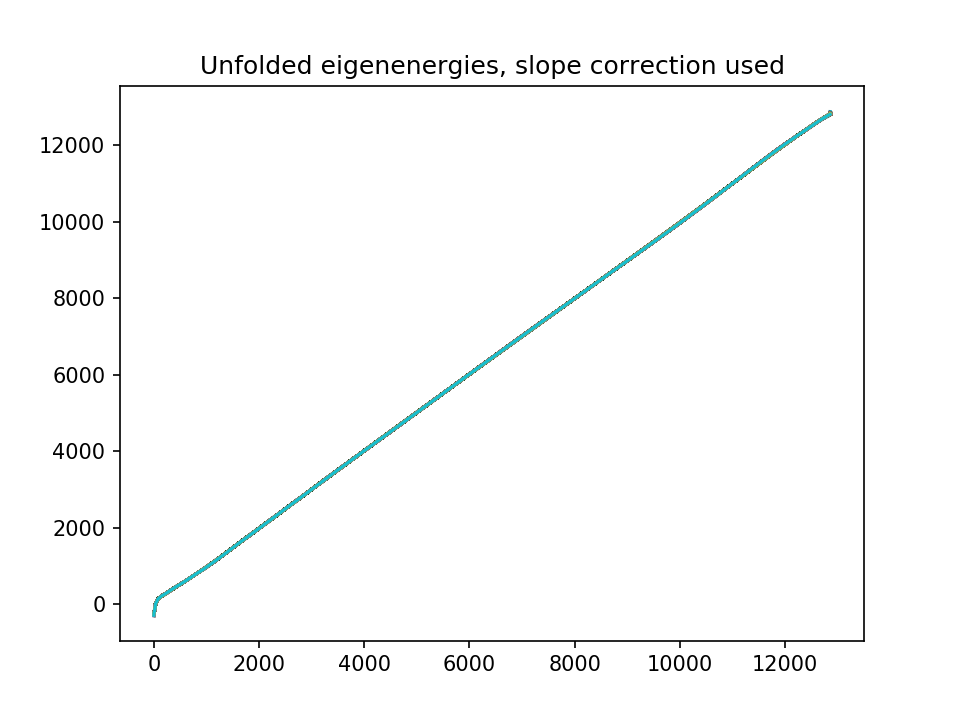

<IPython.core.display.Javascript object>


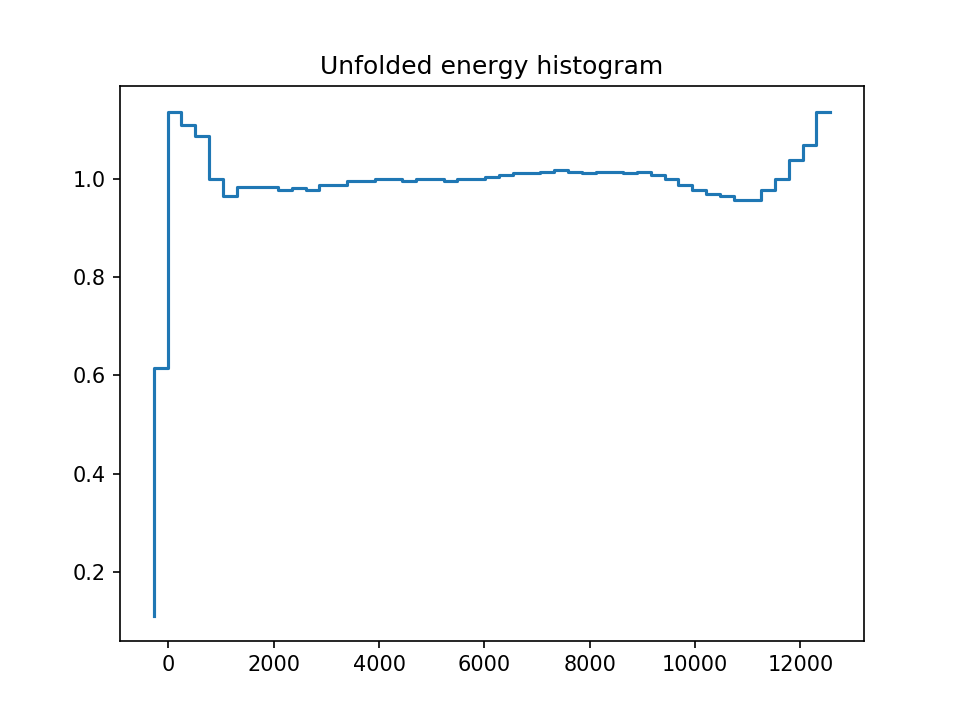

In [7]:
# call the unfolding function again, correct for negative slope effect.
spc.spectral_width = (0., 1)
spc.spectral_unfolding(n=6, merge=False, correct_slope=True);
fig = plt.figure()
plt.title('Unfolded eigenenergies, slope correction used')
for spec in spc.spectrum:
    plt.plot(spec)
plt.show()
hist, edges = spc.hist(bins = 50)
fig = plt.figure()
plt.title('Unfolded energy histogram')
plt.step(edges[:-1], hist*spc.nener)
plt.show()

<IPython.core.display.Javascript object>


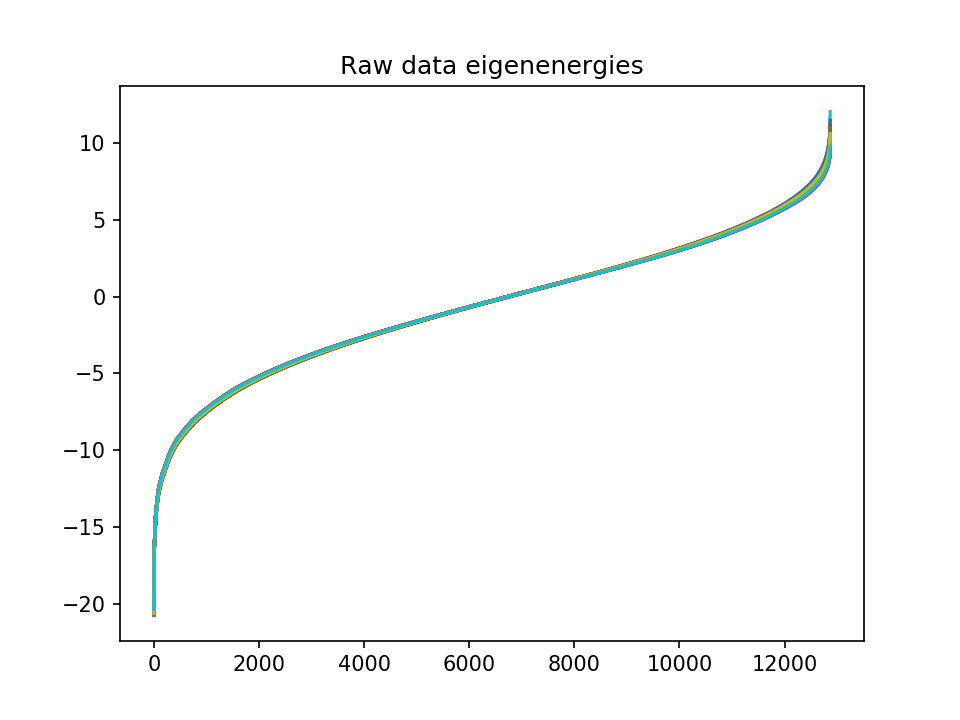

In [8]:
# plot the raw data
spc.spectral_resizing();
fig = plt.figure()
plt.title('Raw data eigenenergies')
for spec in spc.spectrum:
    plt.plot(spec)
plt.show()

In [10]:
spc._resizing_performed

True

The raw data histogram.

<IPython.core.display.Javascript object>


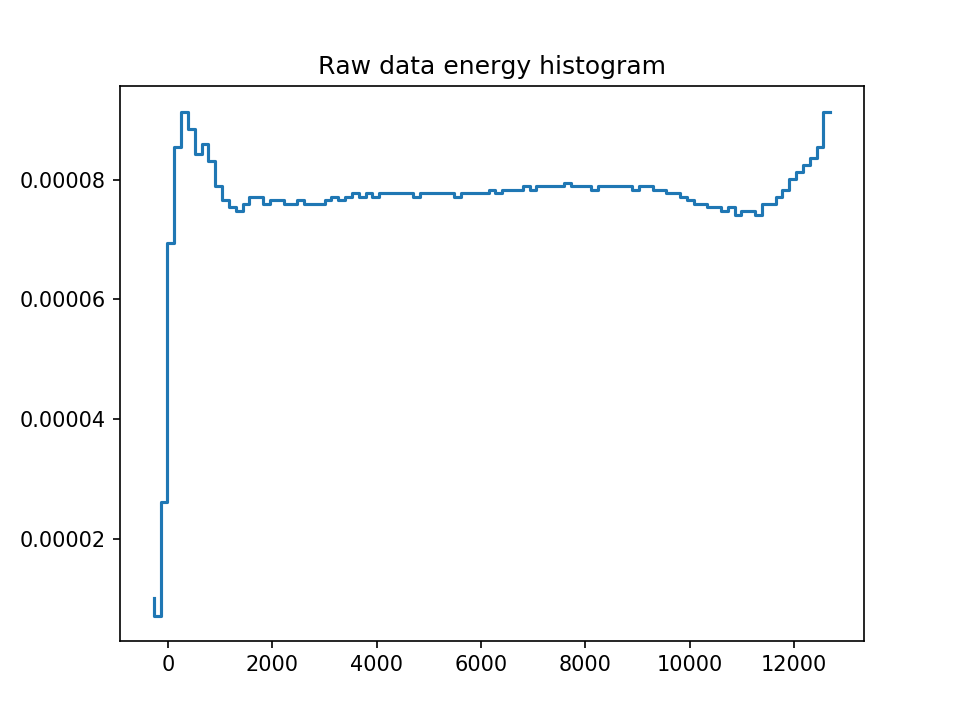

In [7]:
hist, edges = spc.hist(bins = 100)
fig = plt.figure()
plt.title('Raw data energy histogram')
plt.step(edges[:-1], hist)
plt.show()

## Filtering and miscellaneous data calculations

Let us now prepare our data as if we wanted to conduct an actual spectral form factor analysis, starting with data unfolding, proceeding with miscellaneous data calculations and an application of a Gaussian filter.

### LOAD DATA

In [2]:
# we start from scratch; first, load a spectrum
spc = Spectra(spec_erg)

### PERFORM OPERATIONS

In [11]:
# We do the Gaussian filtering. Hence we consider all the states
# in the spectrum
spc.spectral_width = (0., 1.)

# do the unfolding with slope correction, no merging
spc.spectral_unfolding(correct_slope=True, merge=False)

# check the unfolding data
print(spc.unfold_dict)

# calculate misc quantities for the unfolded spectrum
spc.get_ham_misc(individual = True)



Performing spectral unfolding with the following settings: 
n: 3, merge: False, correct_slope: True 
spectral_width: (0.0, 1.0)
{'unfolding_performed': False, 'n': 3, 'merged_unfolding': False, 'correct_slope': True, 'spectral_width': (0.0, 1.0), 'discarded_unfolding': 257}


<IPython.core.display.Javascript object>


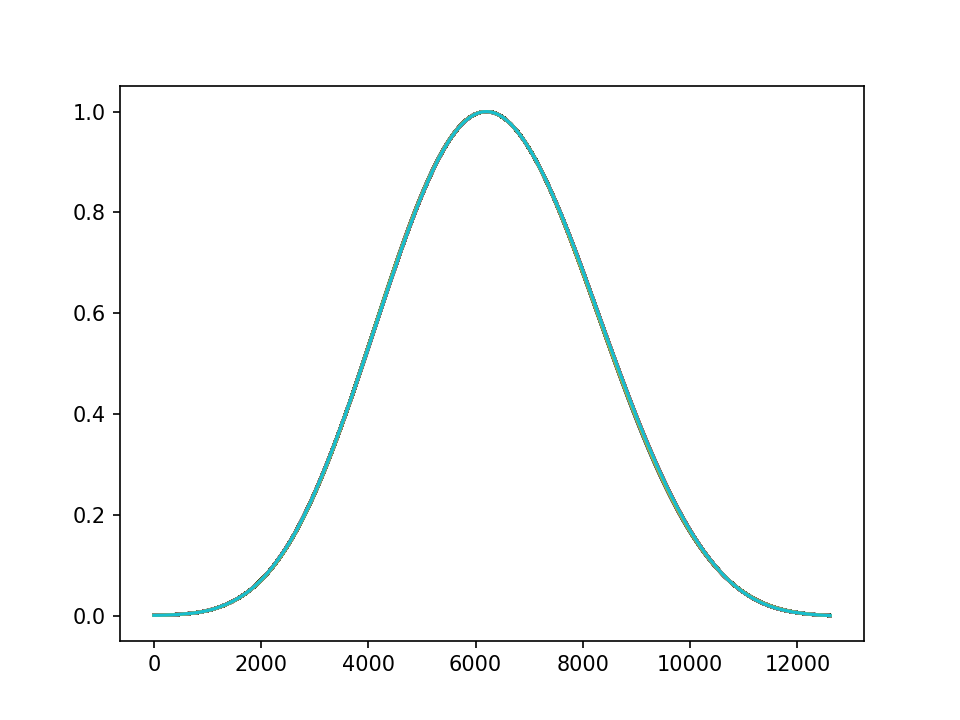

{'mean_ener': -0.5866666666666668,
 'sq_ham_tr': 0.3441777777777778,
 'ham_tr_sq': 20.783839798468826,
 'gamma': 4.520886062116312}

In [24]:
spc.spectral_filtering(filter_key='gaussian', eta = 0.5)
filter_=spc.filt_dict['filter']
fig = plt.figure()
for fil in filter_:
    plt.plot(fil)
plt.show()
spc.filt_dict
spc.misc0_dict

## SFF CALCULATIONS

## Gaussian filtering

In [5]:
spc

<IPython.core.display.Javascript object>


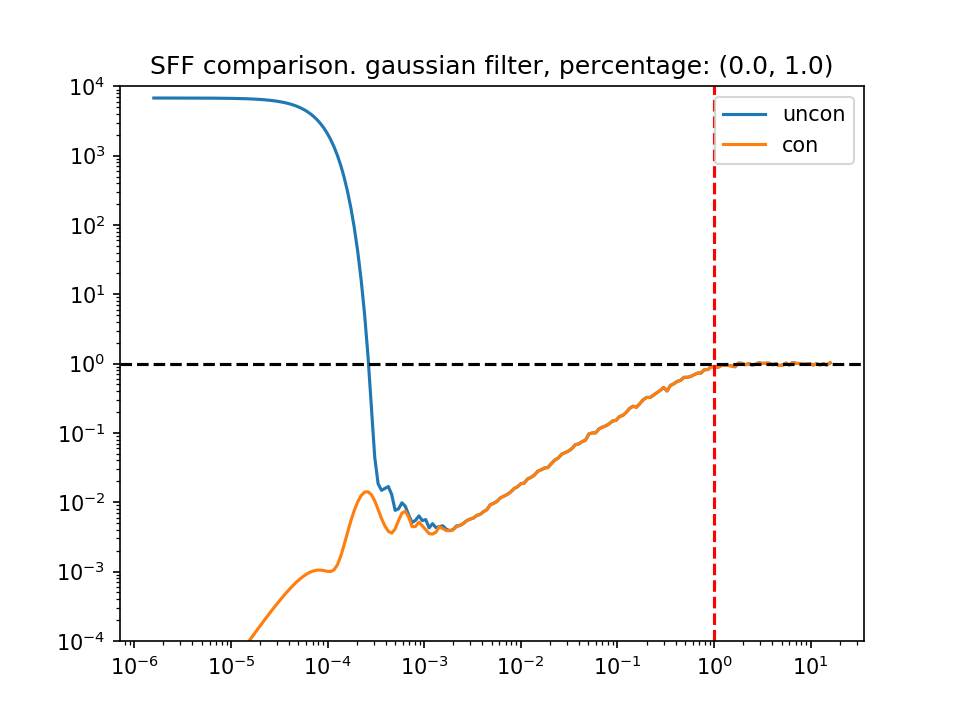

In [25]:
# taulist - check for gaussian filtering
spc.spectral_filtering(filter_key='gaussian', eta = 0.5)


taulist = np.logspace(-5, 2, 200)
spc.calc_sff(taulist)
sffvals = (spc.taulist, spc.sff, spc.sff_uncon)
eff_dim = spc.filt_dict['dims_eff']
A = spc.filt_dict['normal_con']
B = spc.filt_dict['normal_uncon']


fig = plt.figure()
plt.title('SFF comparison. {} filter, percentage: {}'.format(
    spc.filt_dict['filter_type'], spc.spectral_width))
plt.loglog(sffvals[0] / (2 * np.pi), sffvals[1] / eff_dim, label='uncon')
plt.loglog(
    sffvals[0] / (2 * np.pi), (sffvals[1] - (A / B) * sffvals[2]) / eff_dim,
    label='con')
plt.axhline(y=1, ls='--', color='black')
plt.axvline(x=1, ls='--', color='red')
plt.ylim(10**(-4),10**4)
plt.legend()
plt.show()

In [34]:
spc.filt_dict

{'filter': array([[0.00082872, 0.00082886, 0.00082906, ..., 0.00040883, 0.00040529,
         0.00040199],
        [0.0008087 , 0.00080891, 0.00080942, ..., 0.00036595, 0.00036452,
         0.00035927],
        [0.00081881, 0.00081913, 0.00081927, ..., 0.00038406, 0.00038291,
         0.00037721],
        ...,
        [0.00081288, 0.00081335, 0.00081341, ..., 0.00037344, 0.00036602,
         0.00035843],
        [0.00082102, 0.00082124, 0.00082147, ..., 0.00040446, 0.00039916,
         0.0003972 ],
        [0.00080523, 0.00080556, 0.00080561, ..., 0.00035828, 0.00035369,
         0.00034526]]),
 'dims': 12613,
 'dims_eff': 3544.9462057090664,
 'normal_con': 24109080.87798375,
 'normal_uncon': 24109070.584619254,
 'filter_type': 'gaussian',
 'eta': 0.5}

In [7]:
from dataIO.hdf5saver import hdf5load
spc.save('test_saving')
loaded = hdf5load('test_saving')

{'unfolding_performed': False, 'n': 3, 'merged_unfolding': False, 'correct_slope': True, 'spectral_width': (0.0, 1.0), 'discarded_unfolding': 257, 'individual_misc': True, 'dims_eff': 3544.9462057090664, 'normal_con': 24109080.87798375, 'normal_uncon': 24109070.584619254, 'filter_type': 'gaussian', 'eta': 0.5, 'mean_ener0': -0.5866666666666668, 'sq_ham_tr0': 0.3441777777777778, 'ham_tr_sq0': 20.783839798468826, 'gamma0': 4.520886062116312, 'nener': 12613, 'nsamples': 1000, 'nener0': 12870, 'nsamples0': 1000}


In [10]:
print(loaded['metadata']['description'])


    



This hdf5 file stores various spectral statistics calculated on an 

ensemble of energy-spectra of many-body hamiltonians. In the following 

a brief description of file's contents is given. 


The hdf5 file itself contains multiple datasets, which are accessed in a 

manner similar to accesing a python dictionary. We recommend using the user
defined hdf5load() function from the dataIO.hdf5saver module, which is 

distributed alongside the spectral_stats package. The datasets are: 

- spectrum: a 2D ndarray, stores the modified initial ensemble of the 

energy spectra, on which the unfolding and spectral resizing have possibly 

been performed. 

- mean_ener, sq_ham_tr, ham_tr_sq, gamma: 1D ndarrays of the same shape,

their length equals the number of spectra in the ensemble. They store

the value of the mean energy, square of the Hamiltonian's trace, trace

of the squared Hamiltonian and the gamma value of the spectra. Depending

on the choice made during the calculation, the values

In [11]:
spc.misc0_dict

{'mean_ener': -0.5866666666666668,
 'sq_ham_tr': 0.3441777777777778,
 'ham_tr_sq': 20.783839798468826,
 'gamma': 4.520886062116312}

## No filtering

In [62]:
# We do the Gaussian filtering. Hence we consider all the states
# in the spectrum
spc.spectral_width = (0., 1)

# do the unfolding with slope correction, no merging
spc.spectral_unfolding(correct_slope=True, merge=False)

# check the unfolding data
print(spc.unfold_dict)

# calculate misc quantities for the unfolded spectrum
spc.get_ham_misc(individual = True)


Performing spectral unfolding with the following settings: 
n: 3, merge: False, correct_slope: True 
spectral_width: (0.0, 1)
{'n': 3, 'merged': False, 'correct_slope': True, 'spectral_width': (0.0, 1), 'discarded': 485}


<IPython.core.display.Javascript object>


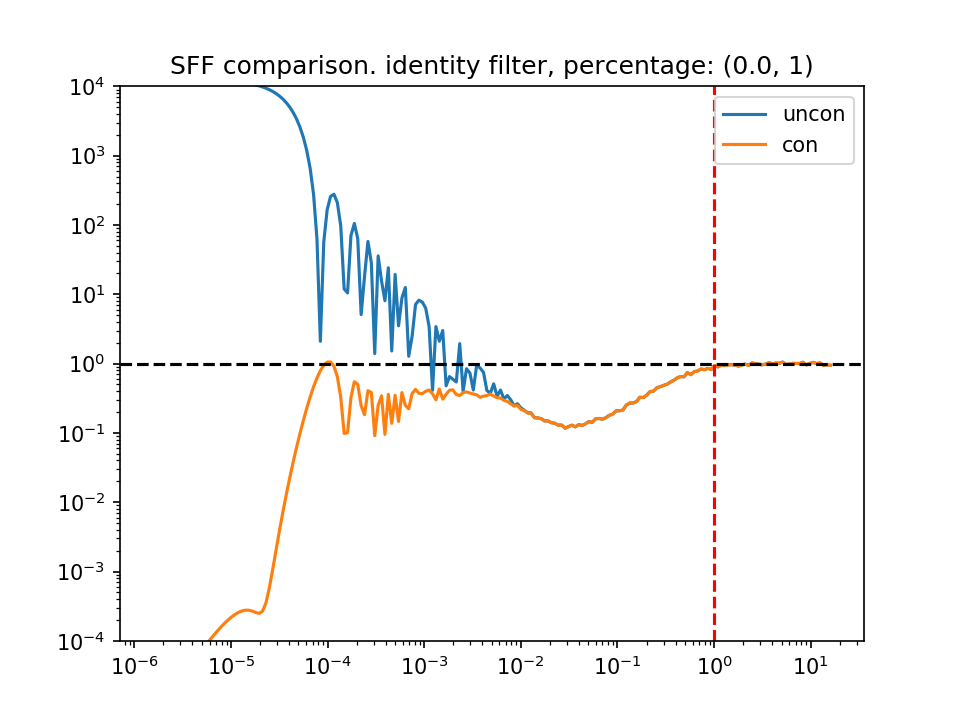

{'filter': array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]]), 'dims': 12385, 'dims_eff': 12385.0, 'normal_con': 153388225.0, 'normal_uncon': 153388225.0, 'unfolded': True, 'type': 'identity', 'spectral_width': (0.0, 1)}


In [63]:
# taulist - check for identity filtering
spc.spectral_filtering(filter_key='identity')
taulist = np.logspace(-5, 2, 200)
sffvals = spc.sff(taulist)
eff_dim = spc.filt_dict['dims_eff']
A = spc.filt_dict['normal_con']
B = spc.filt_dict['normal_uncon']
fig = plt.figure()
plt.title('SFF comparison. {} filter, percentage: {}'.format(
    spc.filt_dict['type'], spc.spectral_width))
plt.loglog(sffvals[0] / (2 * np.pi), sffvals[1] / eff_dim, label='uncon')
plt.loglog(
    sffvals[0] / (2 * np.pi), (sffvals[1] - (A / B) * sffvals[2]) / eff_dim,
    label='con')
plt.axhline(y=1, ls='--', color='black')
plt.axvline(x=1, ls='--', color='red')
plt.ylim(10**(-4),10**4)
plt.legend()
plt.show()
print(spc.filt_dict)

In [96]:
dict_keys = ['filt_con', 'nofilt_con']
filter_keys = {'filt_con': 'gaussian', 'nofilt_con': 'identity'}
dict_inner_keys = {'filt_con':(0.1, 0.3, 0.5, 0.7),  'nofilt_con':(0.1, 0.3, 0.5, 1)}
sff_dict = _makehash()
spc = Spectra(spec_erg)
taulist = np.logspace(-4, 2, 300)
for key in dict_keys:
    for val in dict_inner_keys[key]:
        if filter_keys[key] == 'gaussian':
            spc.spectral_width = (0., 1.)
            eta = val
        else:
            bound = 0.5 * (1 - val)
            spectral_width = (bound, 1 - bound)
            spc.spectral_width = spectral_width
            eta = 1.
        
        spc.spectral_unfolding(correct_slope=True, n=10)
        spc.get_ham_misc()
        spc.spectral_filtering(filter_keys[key], eta)
        sffvals = spc.sff(taulist)
        sff_misc = spc.filt_dict
        
        sff_dict[key][val] = (sffvals, sff_misc)
        
    



Performing spectral unfolding with the following settings: 
n: 10, merge: False, correct_slope: True 
spectral_width: (0.0, 1.0)
Performing spectral unfolding with the following settings: 
n: 10, merge: False, correct_slope: True 
spectral_width: (0.0, 1.0)
Performing spectral unfolding with the following settings: 
n: 10, merge: False, correct_slope: True 
spectral_width: (0.0, 1.0)
Performing spectral unfolding with the following settings: 
n: 10, merge: False, correct_slope: True 
spectral_width: (0.0, 1.0)
Performing spectral unfolding with the following settings: 
n: 10, merge: False, correct_slope: True 
spectral_width: (0.45, 0.55)
Performing spectral unfolding with the following settings: 
n: 10, merge: False, correct_slope: True 
spectral_width: (0.35, 0.65)
Performing spectral unfolding with the following settings: 
n: 10, merge: False, correct_slope: True 
spectral_width: (0.25, 0.75)
Performing spectral unfolding with the following settings: 
n: 10, merge: False, correct_sl

<IPython.core.display.Javascript object>


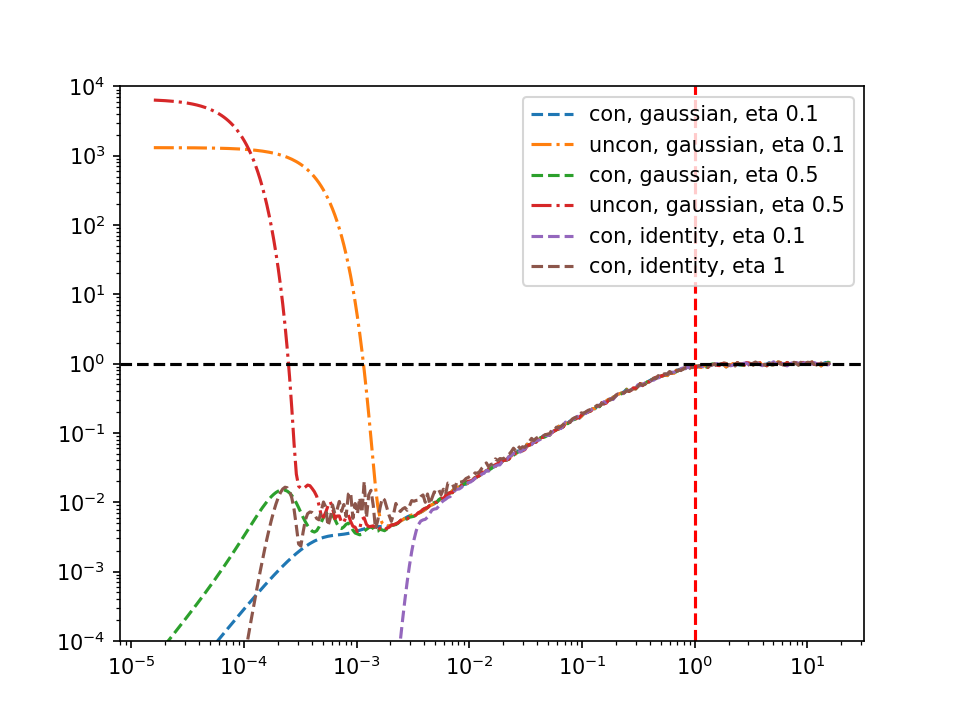

In [83]:
fig = plt.figure()
inner_keys={'filt_con':(0.1, 0.5),  'nofilt_con':(0.1, 1)}
for key1 in sff_dict:
    for key2 in inner_keys[key1]:

        vals = sff_dict[key1][key2]

        eff_dim = vals[1]['dims_eff']
        A = vals[1]['normal_con']
        B = vals[1]['normal_uncon']

        plt.loglog(
            vals[0][0] / (2 * np.pi), (vals[0][1] - (A / B) * vals[0][2]) / eff_dim,
            label='con, {}, eta {}'.format(vals[1]['type'], key2), ls='--')
        if 'nofilt' not in key1:
            plt.loglog(
                vals[0][0] / (2 * np.pi), (vals[0][1]) / eff_dim,
                label='uncon, {}, eta {}'.format(vals[1]['type'], key2), ls='-.')

plt.axhline(y=1, ls='--', color='black')
plt.axvline(x=1, ls='--', color='red')
plt.ylim(10**(-4), 10**4)
plt.legend()
plt.show()
plt.savefig('/Users/jan/Desktop/example_supplemental.pdf')

<IPython.core.display.Javascript object>


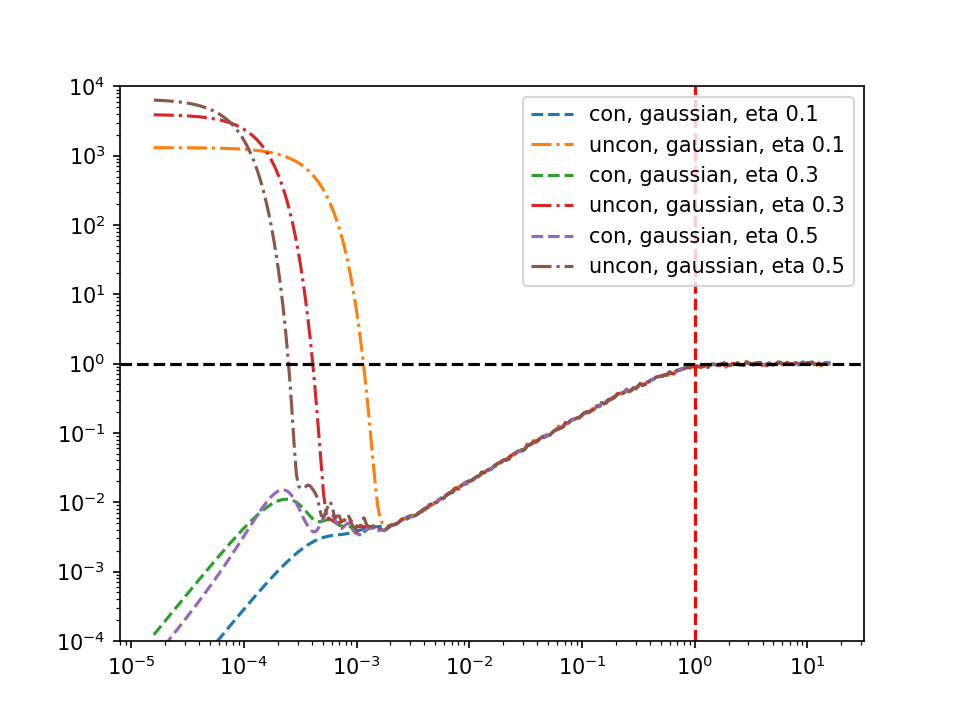

In [84]:
keys = ['filt_con']
fig = plt.figure()
for key1 in keys:
    for key2 in sff_dict[key1]:

        vals = sff_dict[key1][key2]

        eff_dim = vals[1]['dims_eff']
        A = vals[1]['normal_con']
        B = vals[1]['normal_uncon']

        plt.loglog(
            vals[0][0] / (2 * np.pi), (vals[0][1] - (A / B) * vals[0][2]) / eff_dim,
            label='con, {}, eta {}'.format(vals[1]['type'], key2), ls='--')
        if 'nofilt' not in key1:
            plt.loglog(
                vals[0][0] / (2 * np.pi), (vals[0][1]) / eff_dim,
                label='uncon, {}, eta {}'.format(vals[1]['type'], key2), ls='-.')

plt.axhline(y=1, ls='--', color='black')
plt.axvline(x=1, ls='--', color='red')
plt.ylim(10**(-4), 10**4)
plt.legend()
plt.show()
plt.savefig('/Users/jan/Desktop/example_supplemental_filtering.pdf')

<IPython.core.display.Javascript object>


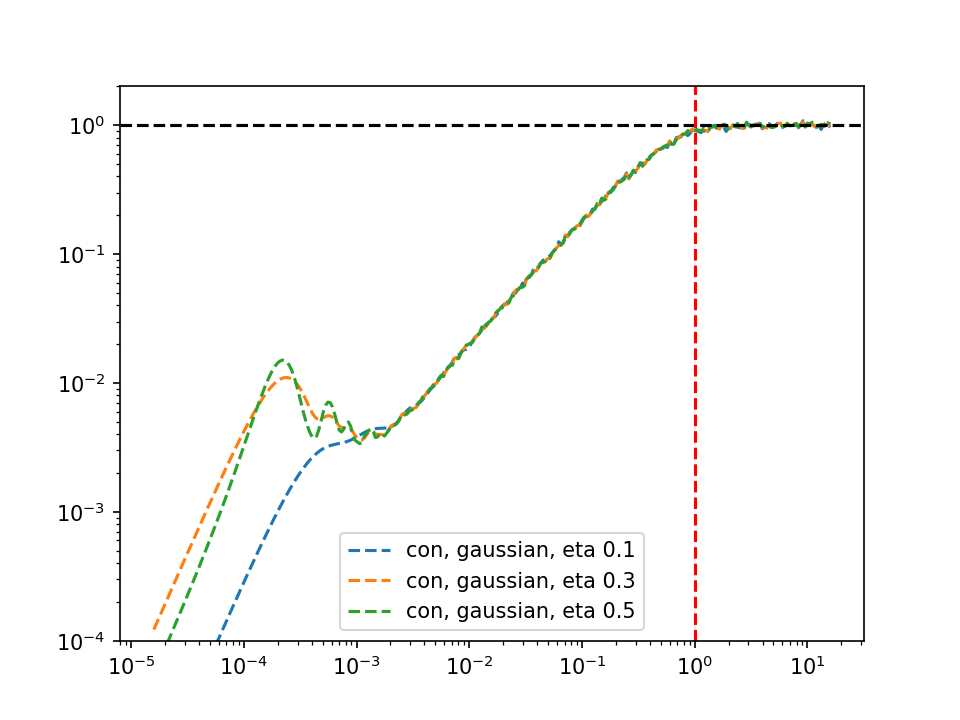

<IPython.core.display.Javascript object>


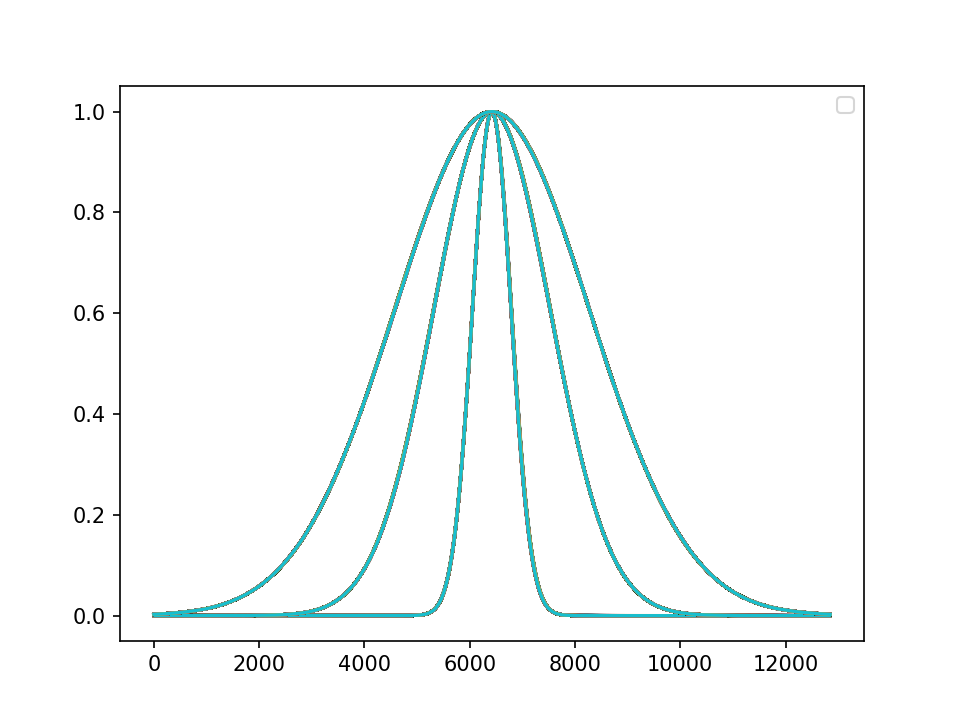

[[9.41924825e-66 9.30844300e-66 8.82255590e-66 ... 4.17484578e-66
  4.03473160e-66 3.96581069e-66]
 [1.67337296e-65 1.65718868e-65 1.04316652e-65 ... 4.10018022e-66
  4.04821450e-66 3.98298572e-66]
 [7.99637611e-66 7.97911886e-66 8.28467435e-66 ... 3.95146410e-66
  3.92794799e-66 3.70219112e-66]
 ...
 [2.13628498e-65 2.09197179e-65 1.12900584e-65 ... 4.22431851e-66
  4.16679520e-66 4.12919399e-66]
 [3.93562863e-66 4.15015388e-66 6.44570220e-66 ... 4.43322329e-66
  4.14133908e-66 3.84872355e-66]
 [1.95674619e-65 1.92085766e-65 1.04602151e-65 ... 3.90360289e-66
  3.84396506e-66 3.81810502e-66]]
[[5.95512242e-08 5.94729761e-08 5.91197669e-08 ... 5.44034843e-08
  5.41975189e-08 5.40938631e-08]
 [6.34777342e-08 6.34092242e-08 6.02305836e-08 ... 5.42945056e-08
  5.42176127e-08 5.41198430e-08]
 [5.84774108e-08 5.84633748e-08 5.87079981e-08 ... 5.40720849e-08
  5.40362349e-08 5.36820089e-08]
 ...
 [6.52238719e-08 6.50721403e-08 6.07621189e-08 ... 5.44747422e-08
  5.43918177e-08 5.43370608e-08]

No handles with labels found to put in legend.


In [95]:
keys = ['filt_con']
fig = plt.figure()
for key1 in keys:
    for key2 in sff_dict[key1]:

        vals = sff_dict[key1][key2]

        eff_dim = vals[1]['dims_eff']
        A = vals[1]['normal_con']
        B = vals[1]['normal_uncon']

        plt.loglog(
            vals[0][0] / (2 * np.pi), (vals[0][1] - (A / B) * vals[0][2]) / eff_dim,
            label='con, {}, eta {}'.format(vals[1]['type'], key2), ls='--')


plt.axhline(y=1, ls='--', color='black')
plt.axvline(x=1, ls='--', color='red')
plt.ylim(10**(-4), 2)
plt.legend()
plt.show()
plt.savefig('/Users/jan/Desktop/example_supplemental_filtering_con.pdf')


fig = plt.figure()
for key1 in keys:
    for key2 in sff_dict[key1]:
        
        vals = sff_dict[key1][key2]
        filt = vals[1]['filter']
        print(filt)
        for fil in filt:
            plt.plot(fil)


plt.legend()
plt.show()

<IPython.core.display.Javascript object>


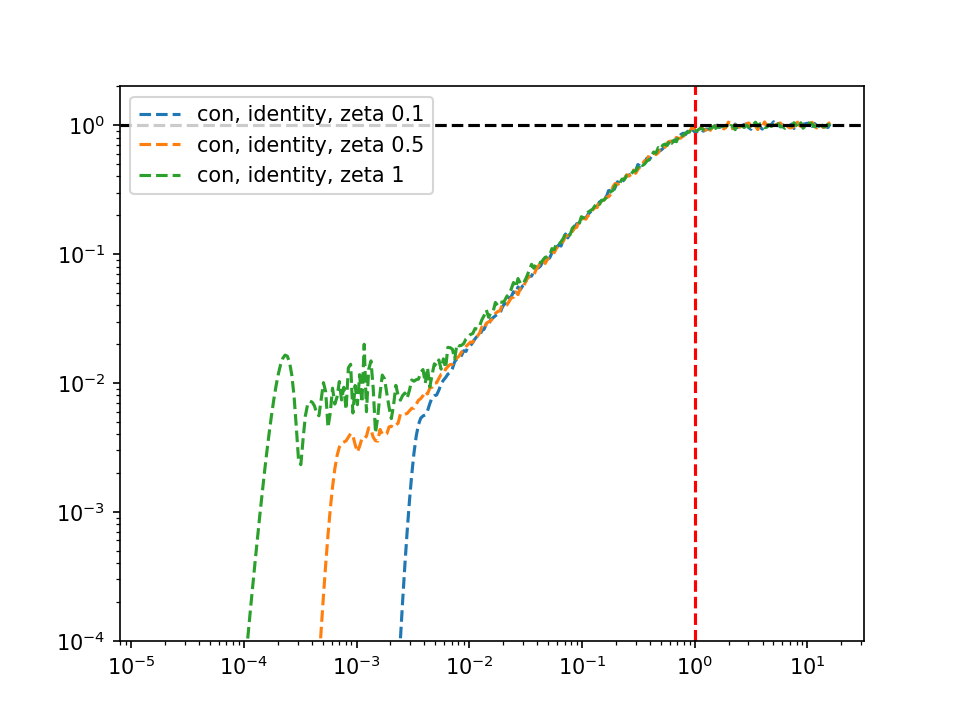

In [86]:
keys = ['nofilt_con']
fig = plt.figure()
for key1 in keys:
    for key2 in sff_dict[key1]:

        vals = sff_dict[key1][key2]

        eff_dim = vals[1]['dims_eff']
        A = vals[1]['normal_con']
        B = vals[1]['normal_uncon']

        plt.loglog(
            vals[0][0] / (2 * np.pi), (vals[0][1] - (A / B) * vals[0][2]) / eff_dim,
            label='con, {}, zeta {}'.format(vals[1]['type'], key2), ls='--')


plt.axhline(y=1, ls='--', color='black')
plt.axvline(x=1, ls='--', color='red')
plt.ylim(10**(-4), 2)
plt.legend()
plt.show()
plt.savefig('/Users/jan/Desktop/example_supplemental_nofilter_con.pdf')

<IPython.core.display.Javascript object>


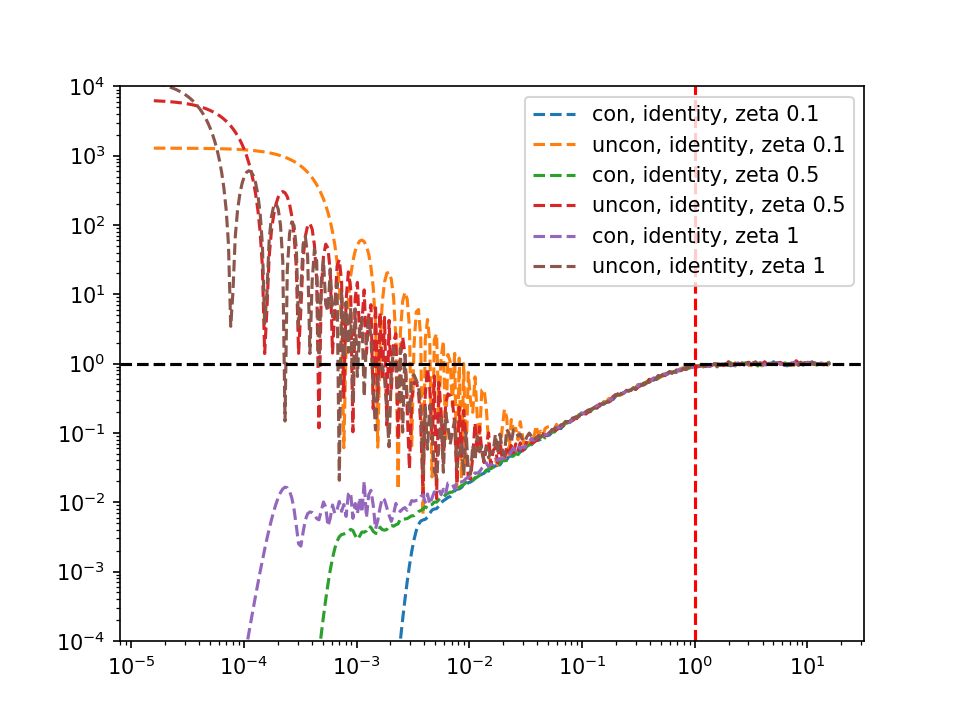

In [87]:
keys = ['nofilt_con']
fig = plt.figure()
for key1 in keys:
    for key2 in sff_dict[key1]:

        vals = sff_dict[key1][key2]

        eff_dim = vals[1]['dims_eff']
        A = vals[1]['normal_con']
        B = vals[1]['normal_uncon']

        plt.loglog(
            vals[0][0] / (2 * np.pi), (vals[0][1] - (A / B) * vals[0][2]) / eff_dim,
            label='con, {}, zeta {}'.format(vals[1]['type'], key2), ls='--')
        plt.loglog(
            vals[0][0] / (2 * np.pi), (vals[0][1]) / eff_dim,
            label='uncon, {}, zeta {}'.format(vals[1]['type'], key2), ls='--')


plt.axhline(y=1, ls='--', color='black')
plt.axvline(x=1, ls='--', color='red')
plt.ylim(10**(-4), 10**4)
plt.legend()
plt.show()
plt.savefig('/Users/jan/Desktop/example_supplemental_nofilter_both.pdf')

## NO UNFOLDING CALCULATIONS

In [89]:
## load the spectrum
spc_nu = Spectra(spec_erg)
## set spectral width


<IPython.core.display.Javascript object>


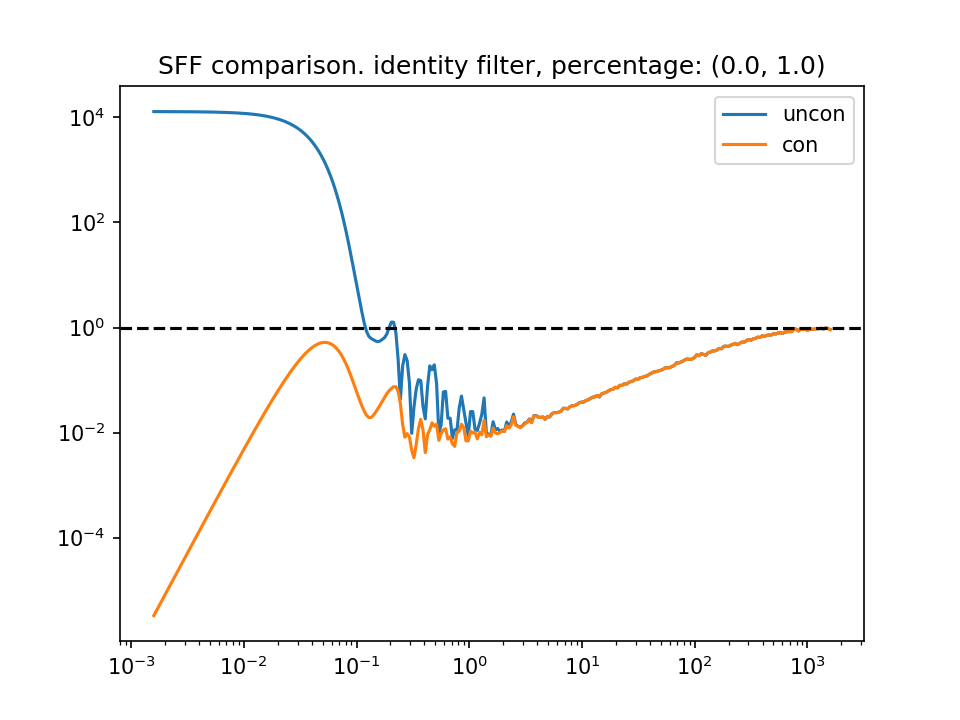

{'filter': array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 'dims': 12870,
 'dims_eff': 12870.0,
 'normal_con': 165636900.0,
 'normal_uncon': 165636900.0,
 'unfolded': False,
 'type': 'identity',
 'spectral_width': (0.0, 1.0)}

In [90]:
# identity filter
spc_nu.spectral_width = (0.,1.)
spc.get_ham_misc()
taulist_ = np.logspace(-2, 4, 300)
spc_nu.spectral_filtering(filter_key='identity')

eff_dim = spc_nu.filt_dict['dims_eff']
A = spc_nu.filt_dict['normal_con']
B = spc_nu.filt_dict['normal_uncon']

sff_nu = spc_nu.sff(taulist_)

fig = plt.figure()
plt.title('SFF comparison. {} filter, percentage: {}'.format(
    spc_nu.filt_dict['type'], spc_nu.spectral_width))
plt.loglog(sff_nu[0] / (2 * np.pi), sff_nu[1] / eff_dim, label='uncon')
plt.loglog(
    sff_nu[0] / (2 * np.pi), (sff_nu[1] - (A / B) * sff_nu[2]) / eff_dim,
    label='con')
plt.axhline(y=1, ls='--', color='black')
#plt.axvline(x=1, ls='--', color='red')
#plt.ylim(10**(-4),10**4)
plt.legend()
plt.show()
spc_nu.filt_dict

<IPython.core.display.Javascript object>


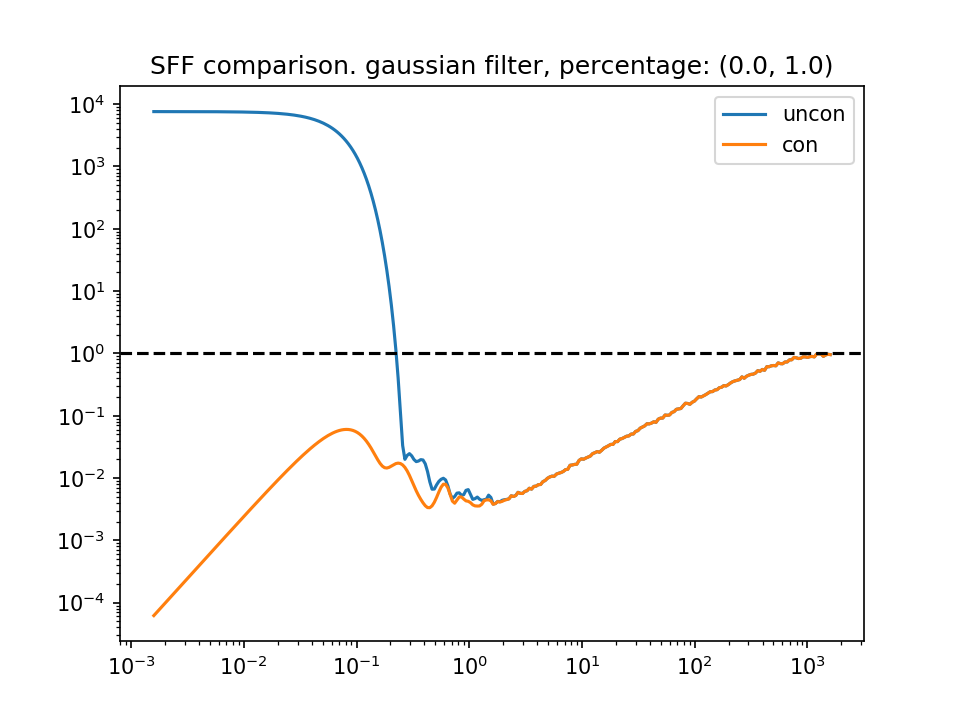

{'filter': array([[8.05258430e-18, 4.08336312e-14, 5.31425984e-14, ...,
         1.21941341e-05, 1.17803210e-05, 8.68487109e-06],
        [1.41414925e-17, 8.19083666e-14, 8.52096122e-14, ...,
         3.07206399e-05, 2.73562194e-05, 2.01955177e-05],
        [1.44060556e-17, 6.56162358e-14, 8.94140745e-14, ...,
         1.57348824e-05, 1.31275648e-05, 1.19003090e-05],
        ...,
        [1.70074106e-17, 1.02548637e-13, 1.09422521e-13, ...,
         3.56147168e-05, 2.93298511e-05, 2.31552506e-05],
        [8.59753467e-18, 4.15843531e-14, 5.38327269e-14, ...,
         7.31988415e-06, 6.05599039e-06, 4.48978319e-06],
        [2.54637243e-17, 1.42135859e-13, 1.51065185e-13, ...,
         4.05104225e-05, 3.44142651e-05, 2.70126603e-05]]),
 'dims': 12870,
 'dims_eff': 4152.999654385781,
 'normal_con': 31559898.11460883,
 'normal_uncon': 31558743.541288383,
 'unfolded': False,
 'type': 'gaussian',
 'spectral_width': (0.0, 1.0)}

In [91]:
# gaussian filter

spc_nu.spectral_width = (0.,1.)
spc_nu.get_ham_misc()
taulist_ = np.logspace(-2, 4, 300)
spc_nu.spectral_filtering(filter_key='gaussian', eta=0.5)

eff_dim = spc_nu.filt_dict['dims_eff']
A = spc_nu.filt_dict['normal_con']
B = spc_nu.filt_dict['normal_uncon']

sff_nu = spc_nu.sff(taulist_)

fig = plt.figure()
plt.title('SFF comparison. {} filter, percentage: {}'.format(
    spc_nu.filt_dict['type'], spc_nu.spectral_width))
plt.loglog(sff_nu[0] / (2 * np.pi), sff_nu[1] / eff_dim, label='uncon')
plt.loglog(
    sff_nu[0] / (2 * np.pi), (sff_nu[1] - (A / B) * sff_nu[2]) / eff_dim,
    label='con')
plt.axhline(y=1, ls='--', color='black')
#plt.axvline(x=1, ls='--', color='red')
#plt.ylim(10**(-4),10**4)
plt.legend()
plt.show()
spc_nu.filt_dict